# 1. get date <a id="a"></a>

In [44]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.manifold import TSNE
from sklearn.metrics import auc,classification_report, precision_recall_curve

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline

In [2]:
data = pd.read_csv("../creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data["Time"] = data["Time"].apply(lambda x:x/3600%24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 2. auto-encoder

In [4]:
## input layer
input_layer = Input(shape=(data.shape[1]-1,))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(data.shape[1]-1, activation='relu')(decoded)

In [5]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [6]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y==0], x_scale[y==1]

In [7]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], batch_size=256,
               epochs = 10, shuffle=True, validation_split=0.20)

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 1s 602us/step - loss: 0.7143 - val_loss: 0.4625
Epoch 2/10
1600/1600 [==============================] - 0s 35us/step - loss: 0.4206 - val_loss: 0.2595
Epoch 3/10
1600/1600 [==============================] - 0s 28us/step - loss: 0.2404 - val_loss: 0.1695
Epoch 4/10
1600/1600 [==============================] - 0s 26us/step - loss: 0.1741 - val_loss: 0.1347
Epoch 5/10
1600/1600 [==============================] - 0s 26us/step - loss: 0.1468 - val_loss: 0.1462
Epoch 6/10
1600/1600 [==============================] - 0s 25us/step - loss: 0.1460 - val_loss: 0.1057
Epoch 7/10
1600/1600 [==============================] - 0s 26us/step - loss: 0.1095 - val_loss: 0.1055
Epoch 8/10
1600/1600 [==============================] - 0s 25us/step - loss: 0.1433 - val_loss: 0.0990
Epoch 9/10
1600/1600 [==============================] - 0s 25us/step - loss: 0.1039 - val_loss: 0.0930
Epoch 10/10
1600/1600 [==

In [8]:
# obtain the latent representations
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [9]:
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [42]:
# def tsne_plot(x1, y1):
#     tsne = TSNE(n_components=2, random_state=0)
#     X_t = tsne.fit_transform(x1)
    
#     plt.figure(figsize=(12, 8))
#     plt.scatter(X_t[np.where(y1==0), 0], X_t[np.where(y1==0),1], 
#                marker='o',color='g', alpha=0.8, label='Non fraud')
#     plt.scatter(X_t[np.where(y1==1), 0], X_t[np.where(y1==1),1], 
#                marker='o',color='r', alpha=0.8, label='fraud')
    
#     plt.legend(loc='best')
#     plt.show()

In [10]:

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [ ]:
tsne_plot(rep_x, rep_y)

# Linear Classifier evaluation

In [12]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print('Classification Report: ')
print(classification_report(val_y, pred_y))

Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     71071
         1.0       0.85      0.47      0.61       131

   micro avg       1.00      1.00      1.00     71202
   macro avg       0.92      0.74      0.80     71202
weighted avg       1.00      1.00      1.00     71202



In [28]:
score_y = clf.predict_proba(val_x)
score_y= score_y[:,1]
score_y

array([0.00106291, 0.00032584, 0.00066198, ..., 0.00052834, 0.00218448,
       0.00051022])

In [29]:
precision, recall, _ = precision_recall_curve(val_y, score_y)

Text(0.5, 1.0, '2-class Precision-Recall curve:')

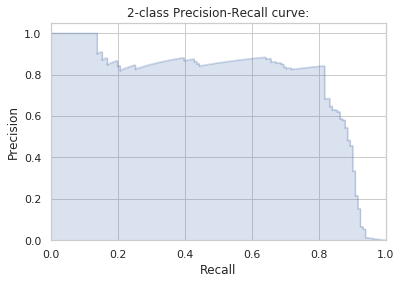

In [34]:
from sklearn.utils.fixes import signature


step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve:')

In [50]:
print("The AUC of precision-recall curve is {:.3f}".format(auc(recall,precision)))

The AUC of precision-recall curve is 0.775
